In [53]:
import pandas as pd
# import dask.dataframe as dd
from datetime import datetime
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from xgboost import XGBRegressor, plot_importance, plot_tree
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
style.use('dark_background')

In [54]:
import mlflow

remote_server_uri = "databricks" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("/my-experiment")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/173139626917049', experiment_id='173139626917049', lifecycle_stage='active', name='/my-experiment', tags={'mlflow.experiment.sourceName': '/my-experiment',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'shivanshug14+unsub@gmail.com',
 'mlflow.ownerId': '3176862807905950'}>

In [55]:
data_path = '/Users/sg/projects/EDS-I-Group-Project/data'

In [56]:
sales = pd.read_csv(f'{data_path}/family_stores_unit_sales.csv').sort_values(by=['year_week', 'family'])
print(sales.shape)
sales.head()

(12672, 5)


,family,store_nbr,year_week,unit_sales,type
0,BEVERAGES,10,201301,4349.0,C
4302,BEVERAGES,27,201301,10020.0,D
7120,BEVERAGES,43,201301,12950.0,E
9854,BEVERAGES,46,201301,24198.0,A
243,BREAD/BAKERY,10,201301,781.0,C


In [57]:
week_dates_df = pd.read_csv(f'{data_path}/week_dates.csv')
week_dates_df['date'] = pd.to_datetime(week_dates_df['date']) + pd.Timedelta(days=1)
week_dates_df

,date
0,2013-01-07
1,2013-01-14
2,2013-01-21
3,2013-01-28
4,2013-02-04
...,...
256,2017-12-04
257,2017-12-11
258,2017-12-18
259,2017-12-25


## Add features for store type to the model
### Y
- Unit Sales for Grocery I
### X
- Year_Week
- type
- num_holidays
- num_events
- avg_oil_price

In [58]:
df = sales.loc[
    (sales['family'] == 'GROCERY I')
].drop(columns=['family', 'store_nbr'])
df['year'] = df['year_week'].apply(lambda x: int(str(x)[:4])) # 201401 --> 2014
df['week'] = df['year_week'].apply(lambda x: int(str(x)[-2:])) # 201401 --> 1
df['date'] = df['year_week'].apply(lambda x: datetime.strptime(str(x) + '-1', '%Y%W-%w'))
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df.reset_index(inplace=True)
df

,date,year_week,unit_sales,type,year,week
0,2013-01-07,201301,16156.000,C,2013,1
1,2013-01-07,201301,16637.000,D,2013,1
2,2013-01-07,201301,18312.000,E,2013,1
3,2013-01-07,201301,67347.000,A,2013,1
4,2013-01-14,201302,11785.000,C,2013,2
...,...,...,...,...,...,...
1100,2017-08-14,201733,5304.000,C,2017,33
1101,2017-08-14,201733,11088.063,B,2017,33
1102,2017-08-14,201733,7886.000,D,2017,33
1103,2017-08-14,201733,9505.218,E,2017,33


Why are we merging with the `weeks` dataframe? 
(See https://github.com/shiv-io/EDS-I-Group-Project/issues/33)

In [59]:
# Make sure there are no missing time-steps
df_ts = pd.merge(
    left=week_dates_df,
    right=df,
    left_on='date',
    right_on='date',
    how='left'
)
df_ts.loc[df_ts['unit_sales'].isna()]

,date,year_week,unit_sales,type,year,week
1105,2017-08-21,NaN,NaN,NaN,NaN,NaN
1106,2017-08-28,NaN,NaN,NaN,NaN,NaN
1107,2017-09-04,NaN,NaN,NaN,NaN,NaN
1108,2017-09-11,NaN,NaN,NaN,NaN,NaN
1109,2017-09-18,NaN,NaN,NaN,NaN,NaN
1110,2017-09-25,NaN,NaN,NaN,NaN,NaN
1111,2017-10-02,NaN,NaN,NaN,NaN,NaN
1112,2017-10-09,NaN,NaN,NaN,NaN,NaN
1113,2017-10-16,NaN,NaN,NaN,NaN,NaN
1114,2017-10-23,NaN,NaN,NaN,NaN,NaN


In [60]:
df_ts = df_ts.loc[df_ts['date']<'2017-08-21']
df_ts

,date,year_week,unit_sales,type,year,week
0,2013-01-07,201301.0,16156.000,C,2013.0,1.0
1,2013-01-07,201301.0,16637.000,D,2013.0,1.0
2,2013-01-07,201301.0,18312.000,E,2013.0,1.0
3,2013-01-07,201301.0,67347.000,A,2013.0,1.0
4,2013-01-14,201302.0,11785.000,C,2013.0,2.0
...,...,...,...,...,...,...
1100,2017-08-14,201733.0,5304.000,C,2017.0,33.0
1101,2017-08-14,201733.0,11088.063,B,2017.0,33.0
1102,2017-08-14,201733.0,7886.000,D,2017.0,33.0
1103,2017-08-14,201733.0,9505.218,E,2017.0,33.0


In [61]:
df_ts = df_ts.join(pd.get_dummies(df_ts['type'])).drop(columns=['type'])
df_ts

,date,year_week,unit_sales,year,week,A,B,C,D,E
0,2013-01-07,201301.0,16156.000,2013.0,1.0,0,0,1,0,0
1,2013-01-07,201301.0,16637.000,2013.0,1.0,0,0,0,1,0
2,2013-01-07,201301.0,18312.000,2013.0,1.0,0,0,0,0,1
3,2013-01-07,201301.0,67347.000,2013.0,1.0,1,0,0,0,0
4,2013-01-14,201302.0,11785.000,2013.0,2.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1100,2017-08-14,201733.0,5304.000,2017.0,33.0,0,0,1,0,0
1101,2017-08-14,201733.0,11088.063,2017.0,33.0,0,1,0,0,0
1102,2017-08-14,201733.0,7886.000,2017.0,33.0,0,0,0,1,0
1103,2017-08-14,201733.0,9505.218,2017.0,33.0,0,0,0,0,1


In [62]:
oil = pd.read_csv(f'{data_path}/oil.csv')
oil['date'] = pd.to_datetime(oil['date'])
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [63]:
oil = pd.DataFrame(oil.set_index('date').resample('1W')['dcoilwtico'].mean())
oil.index = oil.index + pd.Timedelta(days=1)
oil

,dcoilwtico
date,
2013-01-07,93.076667
2013-01-14,93.380000
2013-01-21,94.582000
2013-01-28,95.412500
2013-02-04,97.332000
...,...
2017-08-07,49.520000
2017-08-14,49.076000
2017-08-21,47.524000


In [64]:
oil = pd.merge(
    week_dates_df,
    oil.reset_index(),
    left_on=['date'],
    right_on=['date'],
    how='left'
)
oil

,date,dcoilwtico
0,2013-01-07,93.076667
1,2013-01-14,93.380000
2,2013-01-21,94.582000
3,2013-01-28,95.412500
4,2013-02-04,97.332000
...,...,...
256,2017-12-04,NaN
257,2017-12-11,NaN
258,2017-12-18,NaN
259,2017-12-25,NaN


In [65]:
df = pd.merge(
    left=df_ts,
    right=oil.reset_index(),
    left_on=['date'],
    right_on=['date'],
    how='left'
)[['unit_sales', 'year', 'week', 'A', 'B', 'C', 'D', 'E', 'dcoilwtico']]
df.columns = ['unit_sales', 'year', 'week', 'A', 'B', 'C', 'D', 'E', 'avg_oil_price']
df

,unit_sales,year,week,A,B,C,D,E,avg_oil_price
0,16156.000,2013.0,1.0,0,0,1,0,0,93.076667
1,16637.000,2013.0,1.0,0,0,0,1,0,93.076667
2,18312.000,2013.0,1.0,0,0,0,0,1,93.076667
3,67347.000,2013.0,1.0,1,0,0,0,0,93.076667
4,11785.000,2013.0,2.0,0,0,1,0,0,93.380000
...,...,...,...,...,...,...,...,...,...
1100,5304.000,2017.0,33.0,0,0,1,0,0,49.076000
1101,11088.063,2017.0,33.0,0,1,0,0,0,49.076000
1102,7886.000,2017.0,33.0,0,0,0,1,0,49.076000
1103,9505.218,2017.0,33.0,0,0,0,0,1,49.076000


In [66]:
df.to_csv(f'{data_path}/xgb_time_series_all_stores.csv', index=False)

In [67]:
X = df.iloc[:,1:]
y = df['unit_sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [68]:
import os
model_name = "XGB_Time_Series_All_Stores"
models_dir = '/Users/sg/projects/EDS-I-Group-Project/models'
with mlflow.start_run(run_name=model_name):
    max_depth = 100
    early_stopping_round = 50
    model = XGBRegressor(
        max_depth=100,
        early_stopping_round=50,
        n_jobs=-1,
    )
    # evaluate the model
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
    n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('MAPE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    mlflow.log_metric("MAPE", abs(mean(n_scores)))
    mlflow.log_param("early_stopping_round", early_stopping_round)
    mlflow.log_param("max_depth", max_depth)
    model.fit(X, y)
    mlflow.xgboost.log_model(model, model_name)
    try:
        mlflow.xgboost.save_model(model, path=f'{models_dir}/{model_name}')
    except mlflow.exceptions.MlflowException:
        print("Model directory already exists, model will not be saved.")


MAPE: -0.107 (0.015)
[15:22:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { early_stopping_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Model directory already exists, model will not be saved.


In [69]:
model.fit(X_train, y_train)

[15:22:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { early_stopping_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_round=50,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=100, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

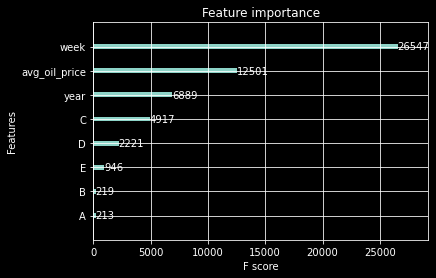

In [70]:
plot_importance(model)

You must install graphviz to plot tree


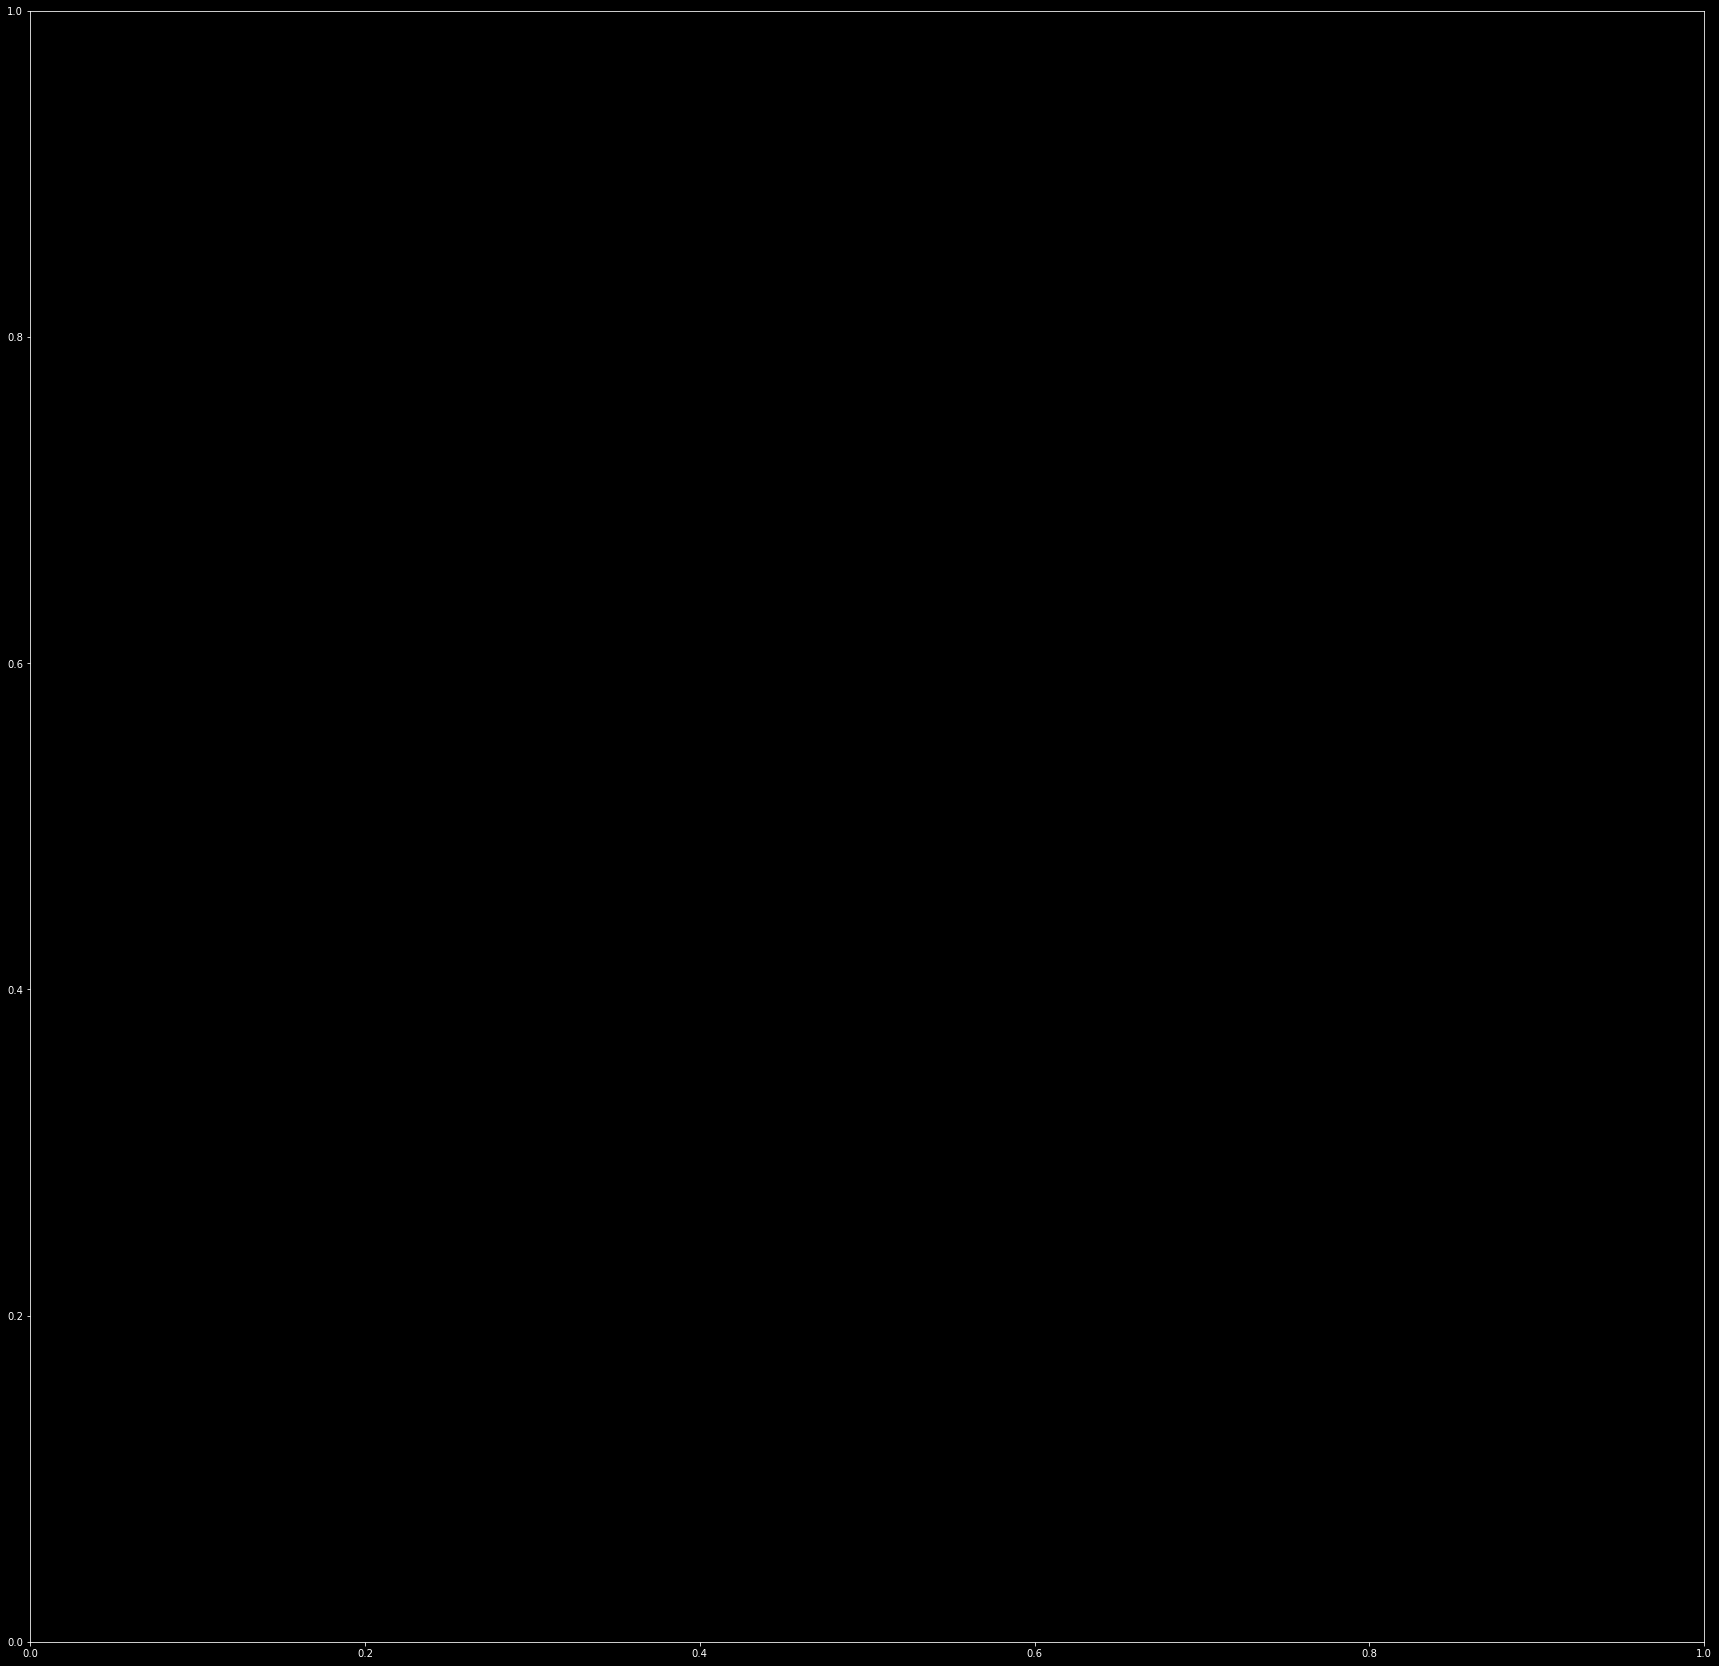

In [71]:
try:
    fig, ax = plt.subplots(figsize=(30, 30))
    plot_tree(model, ax=ax)
    plt.show()
except ImportError as e:
    print(e)

In [72]:
preds = pd.Series(model.predict(X_test)).to_frame()#.reindex(y_test.index)
preds.columns = ['predicted']
preds['actual'] = y_test.to_frame().reset_index()['unit_sales']
preds = preds.join(X_test.reset_index())
preds['year'] = preds['year'].astype(int).astype(str)
preds['week'] = preds['week'].astype(int).astype(str).str.zfill(2)
preds['year_week'] = preds['year'] + preds['week']
preds['date'] = preds['year_week'].apply(lambda x: datetime.strptime(str(x) + '-1', '%Y%W-%w'))
preds = preds.set_index('date').sort_index()
preds

,predicted,actual,index,year,week,A,B,C,D,E,avg_oil_price,year_week
date,,,,,,,,,,,,
2013-01-07,14900.768555,18312.000,2,2013,01,0,0,0,0,1,93.076667,201301
2013-01-07,14175.611328,16637.000,1,2013,01,0,0,0,1,0,93.076667,201301
2013-01-14,11375.968750,13095.000,5,2013,02,0,0,0,1,0,93.380000,201302
2013-01-21,11597.449219,11667.000,8,2013,03,0,0,1,0,0,94.582000,201303
2013-01-21,11668.920898,13618.000,9,2013,03,0,0,0,1,0,94.582000,201303
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-07,16082.169922,41500.501,1096,2017,32,0,1,0,0,0,49.520000,201732
2017-08-07,34317.375000,34445.133,1098,2017,32,0,0,0,0,1,49.520000,201732
2017-08-07,14830.631836,59073.000,1099,2017,32,1,0,0,0,0,49.520000,201732


In [73]:
def plot_predictions_for_store_type(store_type: str):
    title = f'Predicted vs Actual GROCERY I Unit Sales for Store Type {store_type}'
    preds.loc[preds[store_type]==1][['predicted', 'actual']].plot(figsize=(18,8), title=title)

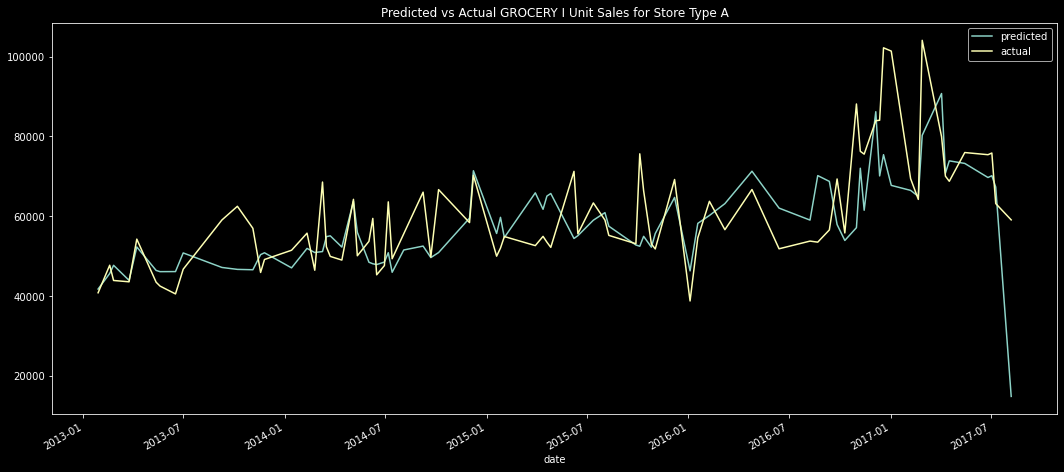

In [74]:
plot_predictions_for_store_type('A')

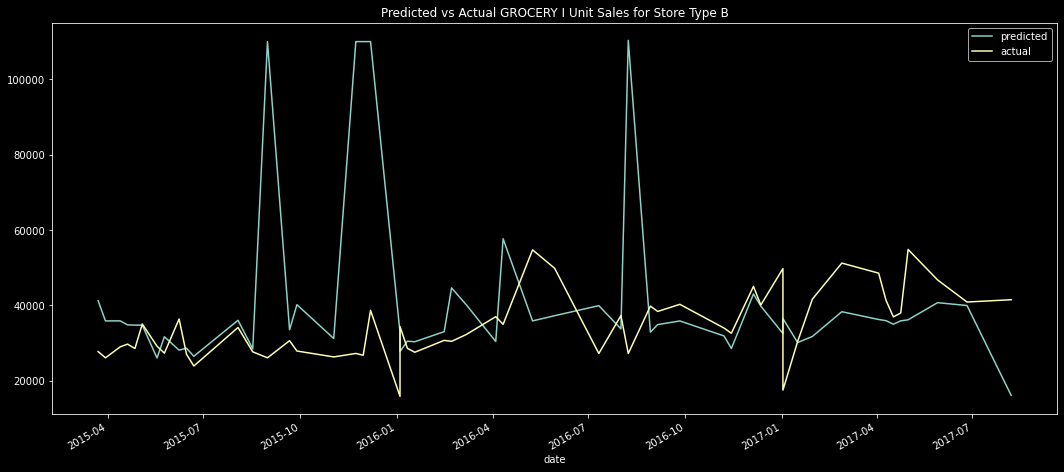

In [75]:
plot_predictions_for_store_type('B')

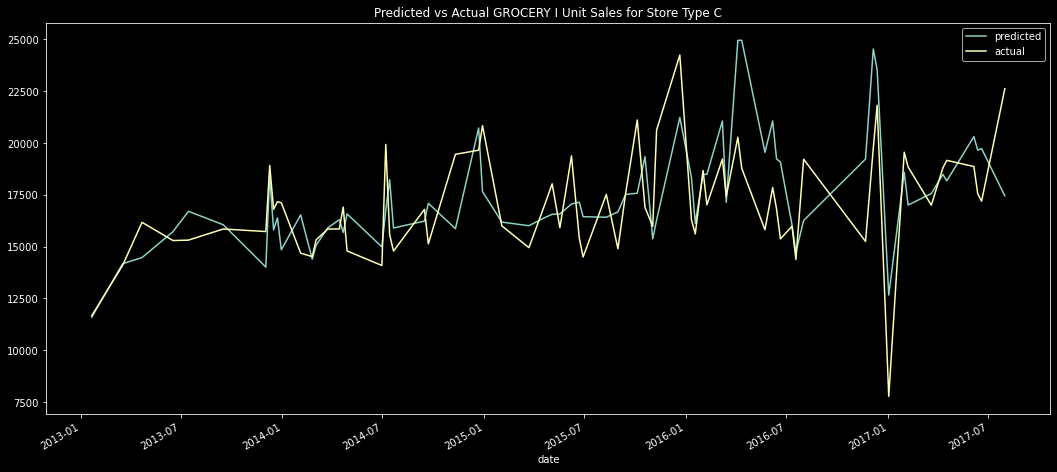

In [76]:
plot_predictions_for_store_type('C')

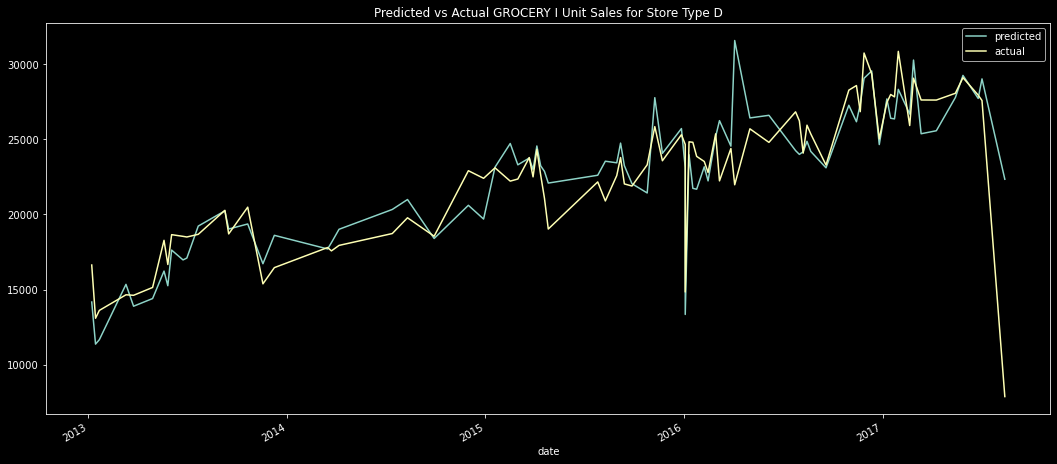

In [77]:
plot_predictions_for_store_type('D')

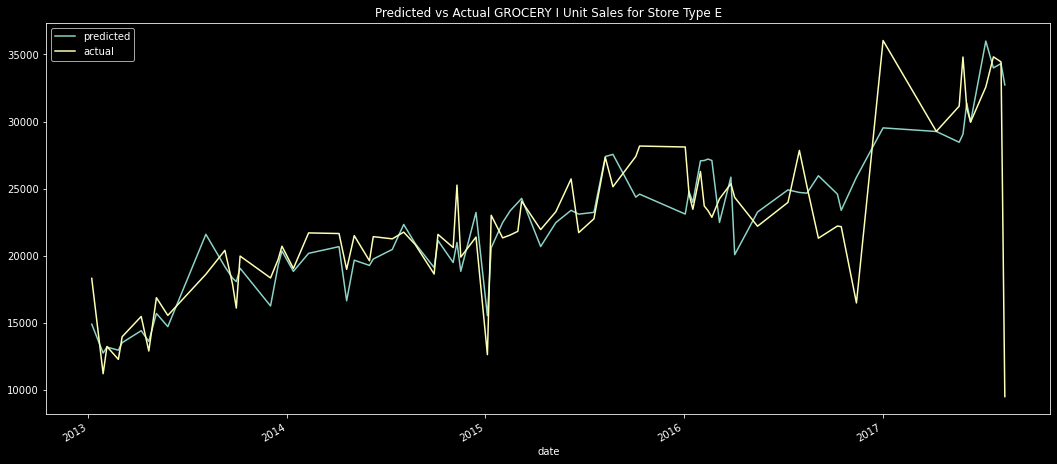

In [78]:
plot_predictions_for_store_type('E')

## Add holiday/event features

In [79]:
hol = pd.read_csv(f'{data_path}/trans_stores_events.csv')
hol

,date,store_nbr,transactions,city,state,type,cluster,is_city_holiday
0,2013-01-01,25,770,Salinas,Santa Elena,D,1,0.0
1,2013-01-02,1,2111,Quito,Pichincha,D,13,0.0
2,2013-01-02,2,2358,Quito,Pichincha,D,13,0.0
3,2013-01-02,3,3487,Quito,Pichincha,D,8,0.0
4,2013-01-02,4,1922,Quito,Pichincha,D,9,0.0
...,...,...,...,...,...,...,...,...
83483,2017-08-15,50,2804,Ambato,Tungurahua,A,14,0.0
83484,2017-08-15,51,1573,Guayaquil,Guayas,A,17,0.0
83485,2017-08-15,52,2255,Manta,Manabi,A,11,0.0
83486,2017-08-15,53,932,Manta,Manabi,D,13,0.0


In [80]:
hol = hol.loc[hol['is_city_holiday']==1].drop(columns='is_city_holiday')
hol['date'] = pd.to_datetime(hol['date'])
hol

,date,store_nbr,transactions,city,state,type,cluster
4632,2013-04-12,37,1250,Cuenca,Azuay,D,2
4634,2013-04-12,39,1247,Cuenca,Azuay,B,6
5028,2013-04-21,14,1111,Riobamba,Chimborazo,C,7
7972,2013-06-23,19,1195,Guaranda,Bolivar,C,15
8059,2013-06-25,12,1214,Latacunga,Cotopaxi,C,15
...,...,...,...,...,...,...,...
81132,2017-07-03,21,1203,Santo Domingo,Santo Domingo de los Tsachilas,B,6
81165,2017-07-03,54,734,El Carmen,Manabi,C,3
82202,2017-07-23,11,2213,Cayambe,Pichincha,B,6
82936,2017-08-05,43,1476,Esmeraldas,Esmeraldas,E,10


In [81]:
grouper = pd.Grouper(key='date', freq='W-MON')
hol_weekly = hol.groupby([grouper, 'type']).count()['city'].to_frame().reset_index().rename(columns={'city': 'num_holidays_weekly'})
hol_weekly

,date,type,num_holidays_weekly
0,2013-04-15,B,1
1,2013-04-15,D,1
2,2013-04-22,C,1
3,2013-06-24,C,1
4,2013-07-01,C,3
...,...,...,...
117,2017-07-03,C,2
118,2017-07-03,D,1
119,2017-07-24,B,1
120,2017-08-07,E,1


In [82]:
hol_weekly_dummies = pd.get_dummies(hol_weekly)
hol_weekly_dummies

,date,num_holidays_weekly,type_A,type_B,type_C,type_D,type_E
0,2013-04-15,1,0,1,0,0,0
1,2013-04-15,1,0,0,0,1,0
2,2013-04-22,1,0,0,1,0,0
3,2013-06-24,1,0,0,1,0,0
4,2013-07-01,3,0,0,1,0,0
...,...,...,...,...,...,...,...
117,2017-07-03,2,0,0,1,0,0
118,2017-07-03,1,0,0,0,1,0
119,2017-07-24,1,0,1,0,0,0
120,2017-08-07,1,0,0,0,0,1


In [83]:
df = pd.merge(
    left=df_ts,
    right=hol_weekly_dummies,
    left_on=['date', 'A', 'B', 'C', 'D', 'E'],
    right_on=['date', 'type_A', 'type_B', 'type_C', 'type_D', 'type_E'],
    how='left'
)
df

,date,year_week,unit_sales,year,week,A,B,C,D,E,num_holidays_weekly,type_A,type_B,type_C,type_D,type_E
0,2013-01-07,201301.0,16156.000,2013.0,1.0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-07,201301.0,16637.000,2013.0,1.0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-07,201301.0,18312.000,2013.0,1.0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,201301.0,67347.000,2013.0,1.0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-14,201302.0,11785.000,2013.0,2.0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,2017-08-14,201733.0,5304.000,2017.0,33.0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1101,2017-08-14,201733.0,11088.063,2017.0,33.0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1102,2017-08-14,201733.0,7886.000,2017.0,33.0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1103,2017-08-14,201733.0,9505.218,2017.0,33.0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
df.drop(columns=['type_A', 'type_B', 'type_C', 'type_D', 'type_E'], inplace=True)
df

,date,year_week,unit_sales,year,week,A,B,C,D,E,num_holidays_weekly
0,2013-01-07,201301.0,16156.000,2013.0,1.0,0,0,1,0,0,NaN
1,2013-01-07,201301.0,16637.000,2013.0,1.0,0,0,0,1,0,NaN
2,2013-01-07,201301.0,18312.000,2013.0,1.0,0,0,0,0,1,NaN
3,2013-01-07,201301.0,67347.000,2013.0,1.0,1,0,0,0,0,NaN
4,2013-01-14,201302.0,11785.000,2013.0,2.0,0,0,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1100,2017-08-14,201733.0,5304.000,2017.0,33.0,0,0,1,0,0,NaN
1101,2017-08-14,201733.0,11088.063,2017.0,33.0,0,1,0,0,0,NaN
1102,2017-08-14,201733.0,7886.000,2017.0,33.0,0,0,0,1,0,NaN
1103,2017-08-14,201733.0,9505.218,2017.0,33.0,0,0,0,0,1,NaN


In [85]:
df['num_holidays_weekly'].fillna(0, inplace=True)
df

,date,year_week,unit_sales,year,week,A,B,C,D,E,num_holidays_weekly
0,2013-01-07,201301.0,16156.000,2013.0,1.0,0,0,1,0,0,0.0
1,2013-01-07,201301.0,16637.000,2013.0,1.0,0,0,0,1,0,0.0
2,2013-01-07,201301.0,18312.000,2013.0,1.0,0,0,0,0,1,0.0
3,2013-01-07,201301.0,67347.000,2013.0,1.0,1,0,0,0,0,0.0
4,2013-01-14,201302.0,11785.000,2013.0,2.0,0,0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1100,2017-08-14,201733.0,5304.000,2017.0,33.0,0,0,1,0,0,0.0
1101,2017-08-14,201733.0,11088.063,2017.0,33.0,0,1,0,0,0,0.0
1102,2017-08-14,201733.0,7886.000,2017.0,33.0,0,0,0,1,0,0.0
1103,2017-08-14,201733.0,9505.218,2017.0,33.0,0,0,0,0,1,0.0


In [86]:
df = pd.merge(
    left=df,
    right=oil.reset_index(),
    left_on=['date'],
    right_on=['date'],
    how='left'
)
df

,date,year_week,unit_sales,year,week,A,B,C,D,E,num_holidays_weekly,index,dcoilwtico
0,2013-01-07,201301.0,16156.000,2013.0,1.0,0,0,1,0,0,0.0,0,93.076667
1,2013-01-07,201301.0,16637.000,2013.0,1.0,0,0,0,1,0,0.0,0,93.076667
2,2013-01-07,201301.0,18312.000,2013.0,1.0,0,0,0,0,1,0.0,0,93.076667
3,2013-01-07,201301.0,67347.000,2013.0,1.0,1,0,0,0,0,0.0,0,93.076667
4,2013-01-14,201302.0,11785.000,2013.0,2.0,0,0,1,0,0,0.0,1,93.380000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,2017-08-14,201733.0,5304.000,2017.0,33.0,0,0,1,0,0,0.0,240,49.076000
1101,2017-08-14,201733.0,11088.063,2017.0,33.0,0,1,0,0,0,0.0,240,49.076000
1102,2017-08-14,201733.0,7886.000,2017.0,33.0,0,0,0,1,0,0.0,240,49.076000
1103,2017-08-14,201733.0,9505.218,2017.0,33.0,0,0,0,0,1,0.0,240,49.076000


In [87]:
features = [
    'year',
    'week',
    'A', 'B', 'C', 'D', 'E',
    'num_holidays_weekly',
    'dcoilwtico'
]
X = df[features]
y = df['unit_sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [88]:
model_name = "XGB_Time_Series_All_Stores_With_Holidays"
with mlflow.start_run(run_name=model_name):
    model = XGBRegressor(
        max_depth=max_depth,
        early_stopping_round=early_stopping_round,
        n_jobs=-1,
    )
    # evaluate the model
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
    n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('MAPE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    mlflow.log_metric("MAPE", abs(mean(n_scores)))
    mlflow.log_param("early_stopping_round", early_stopping_round)
    mlflow.log_param("max_depth", max_depth)
    model.fit(X, y)
    mlflow.xgboost.log_model(model, model_name)
    try:
        mlflow.xgboost.save_model(model, path=f'/Users/sg/projects/EDS-I-Group-Project/models/{model_name}')
    except mlflow.exceptions.MlflowException:
        print("Model directory already exists, model will not be saved.")

MAPE: -0.112 (0.019)
[15:22:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { early_stopping_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


